<a href="https://colab.research.google.com/github/rikunemu/colab_study/blob/main/pose_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  mediapipeで取った特徴点を分析

90分対策  
F12を開いて以下のスクリプトをコンソールで実行  
function KeepClicking(){
console.log("Clicking");
document.querySelector("colab-connect-button").click()
}
setInterval(KeepClicking,600000)

  
10分ごとに接続

参考url:
https://sunnyday-travel-aso-6487.ssl-lolipop.jp/programing/python/keras/lstm-use/

In [1]:
import sys
from google.colab import drive
import numpy as np
import pandas as pd
from pandas import Series,DataFrame
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import csv
import os
import keras

from keras.models import Sequential
from keras.layers.core import Activation
from keras.layers.core import Dense
from keras.layers.core import Dropout
from keras.layers.recurrent import LSTM
#from keras.optimizers import RMSprop
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import utils as np_utils
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping,ModelCheckpoint
#from tensorflow.keras.initializers import glorot_uniform
#from tensorflow.keras.initializers import orthogonal
#from tensorflow.keras.initializers import TruncatedNormal
drive.mount("/content/drive")

Mounted at /content/drive


## csvデータ読み込み
train,test,validそれぞれ7感情の特徴点を記録

In [2]:
fp_train='/content/drive/MyDrive/data分析/join_csv/csvtrainresult.csv'
df_train=pd.read_csv(fp_train)
fp_test='/content/drive/MyDrive/data分析/join_csv/csvtestresult.csv'
df_test=pd.read_csv(fp_test)

In [3]:
df_train

,Unnamed: 0,right_hand_0_x,right_hand_0_y,right_hand_0_z,right_hand_1_x,right_hand_1_y,right_hand_1_z,right_hand_2_x,right_hand_2_y,right_hand_2_z,right_hand_3_x,right_hand_3_y,right_hand_3_z,right_hand_4_x,right_hand_4_y,right_hand_4_z,right_hand_5_x,right_hand_5_y,right_hand_5_z,right_hand_6_x,right_hand_6_y,right_hand_6_z,right_hand_7_x,right_hand_7_y,right_hand_7_z,right_hand_8_x,right_hand_8_y,right_hand_8_z,right_hand_9_x,right_hand_9_y,right_hand_9_z,right_hand_10_x,right_hand_10_y,right_hand_10_z,right_hand_11_x,right_hand_11_y,right_hand_11_z,right_hand_12_x,right_hand_12_y,right_hand_12_z,...,pose_20_x,pose_20_y,pose_20_z,pose_21_x,pose_21_y,pose_21_z,pose_22_x,pose_22_y,pose_22_z,pose_23_x,pose_23_y,pose_23_z,pose_24_x,pose_24_y,pose_24_z,pose_25_x,pose_25_y,pose_25_z,pose_26_x,pose_26_y,pose_26_z,pose_27_x,pose_27_y,pose_27_z,pose_28_x,pose_28_y,pose_28_z,pose_29_x,pose_29_y,pose_29_z,pose_30_x,pose_30_y,pose_30_z,pose_31_x,pose_31_y,pose_31_z,pose_32_x,pose_32_y,pose_32_z,correct
0,0,0.2224442958831787,0.4422075152397156,3.7131806518431172e-09,0.2446900308132172,0.4149693548679352,0.0010840819450095296,0.25893548130989075,0.3752827942371368,0.0013474832521751525,0.2711987793445587,0.34823906421661377,0.0004931083531118928,0.2849489748477936,0.3384552597999573,-0.0008215907728299499,0.2459968477487564,0.3207865357398987,0.0010105961700901391,0.24699611961841586,0.269858181476593,-0.001927349832840264,0.2453041523694992,0.24532273411750796,-0.004461469128727913,0.2431216835975647,0.2268707752227783,-0.006229042541235685,0.2319561392068863,0.31679993867874146,-0.0027568282093852763,0.2317588776350021,0.2564876079559326,-0.00549296336248517,0.2303530871868133,0.22836440801620486,-0.007513924967497587,0.2289526164531708,0.20826973021030426,-0.008907853625714779,...,0.236970,0.328482,-0.960857,0.486968,1.013701,-0.431282,0.247595,0.365244,-0.884852,0.525807,0.990230,-0.001249,0.398578,0.994267,0.000865,0.556781,1.340525,-0.258154,0.381583,1.349787,-0.126058,0.535659,1.667566,0.044337,0.383731,1.729255,0.178774,0.543372,1.709012,0.064809,0.384338,1.789304,0.203519,0.479335,1.806632,-0.158263,0.396904,1.856089,-0.012786,1
1,4,0.22203293442726132,0.4334453344345093,1.2514276193087426e-07,0.24396806955337524,0.4106791019439697,-0.003519897814840078,0.25952497124671936,0.3746607899665833,-0.005198152735829353,0.2714368402957916,0.3486778736114502,-0.007344696205109358,0.2840065956115723,0.3383833169937134,-0.00978426355868578,0.244074285030365,0.3235339820384979,-0.001337761990725994,0.24491819739341736,0.27855125069618225,-0.005324040539562702,0.2436306774616241,0.25265973806381226,-0.009328738786280157,0.2423679381608963,0.2317902743816376,-0.01220017112791538,0.2305390983819961,0.3196403980255127,-0.003323586657643318,0.2306264340877533,0.2688789069652557,-0.006567883770912886,0.22982580959796906,0.2377839833498001,-0.010503385215997696,0.22895538806915286,0.21382276713848114,-0.013305600732564926,...,0.237208,0.327864,-0.910904,0.484806,1.014298,-0.392366,0.248362,0.365735,-0.837397,0.526047,0.991439,-0.005950,0.398112,0.996372,0.005553,0.553778,1.364288,-0.223747,0.384069,1.368387,-0.114935,0.532262,1.699656,0.046893,0.386445,1.738648,0.202262,0.538874,1.743304,0.064097,0.387208,1.795833,0.229034,0.480376,1.838793,-0.155816,0.398032,1.867071,0.027943,1
2,8,0.22244857251644132,0.432775616645813,1.302594370145016e-07,0.2442791312932968,0.4108392298221588,-0.004733189009130001,0.25980040431022644,0.37475201487541204,-0.006571783218532801,0.2717142701148987,0.34872347116470337,-0.008704772219061852,0.2842200994491577,0.3388676345348358,-0.011092783883213995,0.2437115460634232,0.32336825132369995,-0.001780985970981419,0.24486954510211945,0.2790630757808685,-0.006071990821510553,0.2436429262161255,0.2531093955039978,-0.01042267307639122,0.2423101961612701,0.2319216132164001,-0.013577163219451904,0.23021599650383,0.3195566833019257,-0.003355564083904028,0.2302461862564087,0.2693890929222107,-0.007015510462224484,0.229491382837

In [4]:
df_test

,Unnamed: 0,right_hand_0_x,right_hand_0_y,right_hand_0_z,right_hand_1_x,right_hand_1_y,right_hand_1_z,right_hand_2_x,right_hand_2_y,right_hand_2_z,right_hand_3_x,right_hand_3_y,right_hand_3_z,right_hand_4_x,right_hand_4_y,right_hand_4_z,right_hand_5_x,right_hand_5_y,right_hand_5_z,right_hand_6_x,right_hand_6_y,right_hand_6_z,right_hand_7_x,right_hand_7_y,right_hand_7_z,right_hand_8_x,right_hand_8_y,right_hand_8_z,right_hand_9_x,right_hand_9_y,right_hand_9_z,right_hand_10_x,right_hand_10_y,right_hand_10_z,right_hand_11_x,right_hand_11_y,right_hand_11_z,right_hand_12_x,right_hand_12_y,right_hand_12_z,...,pose_20_x,pose_20_y,pose_20_z,pose_21_x,pose_21_y,pose_21_z,pose_22_x,pose_22_y,pose_22_z,pose_23_x,pose_23_y,pose_23_z,pose_24_x,pose_24_y,pose_24_z,pose_25_x,pose_25_y,pose_25_z,pose_26_x,pose_26_y,pose_26_z,pose_27_x,pose_27_y,pose_27_z,pose_28_x,pose_28_y,pose_28_z,pose_29_x,pose_29_y,pose_29_z,pose_30_x,pose_30_y,pose_30_z,pose_31_x,pose_31_y,pose_31_z,pose_32_x,pose_32_y,pose_32_z,correct
0,0,0.22479528188705444,0.43833065032958973,2.8026452270069058e-08,0.2476282119750977,0.4129495322704315,0.002200427930802107,0.2612107396125793,0.3775031566619873,0.003275654744356871,0.27197450399398804,0.3495721220970154,0.003145982278510928,0.2834574282169342,0.3366932570934296,0.0027186768129467964,0.2476832270622253,0.32006388902664185,0.003314359812065959,0.2485579401254654,0.2685950100421905,0.001506124623119831,0.2467489838600159,0.2439494580030441,-0.00039139878936111927,0.2447202503681183,0.22535838186740875,-0.0017173198284581306,0.2334853708744049,0.31530797481536865,-0.0003208010166417808,0.23339083790779114,0.2558111548423767,-0.0021328486036509275,0.2325165718793869,0.2269885540008545,-0.003903162432834506,0.2318382859230041,0.20705287158489227,-0.005123055074363947,...,0.242234,0.316324,-0.924460,0.529181,0.982548,-0.299934,0.253501,0.353029,-0.849290,0.525136,0.993285,0.011237,0.395139,1.000884,-0.011601,0.538185,1.401839,-0.005322,0.386646,1.384791,-0.046022,0.516963,1.726134,0.227829,0.378278,1.722241,0.283497,0.518436,1.773355,0.240551,0.374241,1.771939,0.312350,0.491024,1.860005,0.054467,0.398374,1.854283,0.153600,1
1,2,0.2249705940485001,0.4312048852443695,1.2126399440148814e-07,0.2467975914478302,0.4088885486125946,-0.0031440174207091327,0.26141175627708435,0.37526896595954895,-0.004716620780527593,0.2721168398857117,0.349424421787262,-0.006717429962009192,0.2839614152908325,0.3372560143470764,-0.008893478661775589,0.24614648520946505,0.3197603523731232,-0.0006276476196944714,0.2470621913671493,0.27312415838241577,-0.004008668474853039,0.2458183914422989,0.2474576234817505,-0.0075128874741494656,0.2447675466537476,0.2273153364658356,-0.009928427636623384,0.2325818240642548,0.3156845569610596,-0.002320723840966821,0.232641875743866,0.26371172070503235,-0.004937151912599802,0.2318606823682785,0.2326425909996033,-0.008356948383152485,0.2313550561666489,0.2088032960891724,-0.01082521490752697,...,0.240998,0.317401,-0.992762,0.525426,0.988537,-0.375969,0.251129,0.353485,-0.912511,0.523307,0.991387,0.014030,0.392789,0.996508,-0.014367,0.536857,1.393194,-0.026212,0.387384,1.372952,-0.093690,0.520206,1.715370,0.216148,0.383692,1.716836,0.233262,0.522390,1.763156,0.228782,0.380784,1.768322,0.261080,0.494069,1.845846,0.028678,0.403086,1.847850,0.086708,1
2,4,0.225164458155632,0.4281842410564423,1.2957912076672073e-07,0.24652674794197085,0.4083037376403809,-0.004722658544778824,0.2612020075321197,0.3750335872173309,-0.006881076376885176,0.2718014717102051,0.34940049052238464,-0.00926367659121752,0.2835273146629333,0.3376174867153168,-0.011834239587187769,0.24577778577804565,0.3200258016586304,-0.002090181689709425,0.24697110056877136,0.2751700282096863,-0.006119192577898502,0.2458709627389908,0.2495443671941757,-0.010212635621428491,0.24465055763721466,0.2288790196180344,-0.013100861571729185,0.2327941954135895,0.3158749938011169,-0.0033745833206921816,0.23295752704143524,0.26527762413024897,-0.006511099636554718,0.2323255240

In [5]:
df_test.shape

(6000, 164)

Unnameはいらないので削除

In [6]:
df_test=df_test.replace('NAN',0.1)
df_train=df_train.replace('NAN',0.1)

In [7]:
df_train=df_train.drop(columns=df_train.columns[[0]],axis=1)

967,5,17

In [8]:
df_test=df_test.drop(columns=df_test.columns[[0]],axis=1)

3659,4  
30,487

In [9]:
df_train

,right_hand_0_x,right_hand_0_y,right_hand_0_z,right_hand_1_x,right_hand_1_y,right_hand_1_z,right_hand_2_x,right_hand_2_y,right_hand_2_z,right_hand_3_x,right_hand_3_y,right_hand_3_z,right_hand_4_x,right_hand_4_y,right_hand_4_z,right_hand_5_x,right_hand_5_y,right_hand_5_z,right_hand_6_x,right_hand_6_y,right_hand_6_z,right_hand_7_x,right_hand_7_y,right_hand_7_z,right_hand_8_x,right_hand_8_y,right_hand_8_z,right_hand_9_x,right_hand_9_y,right_hand_9_z,right_hand_10_x,right_hand_10_y,right_hand_10_z,right_hand_11_x,right_hand_11_y,right_hand_11_z,right_hand_12_x,right_hand_12_y,right_hand_12_z,right_hand_13_x,...,pose_20_x,pose_20_y,pose_20_z,pose_21_x,pose_21_y,pose_21_z,pose_22_x,pose_22_y,pose_22_z,pose_23_x,pose_23_y,pose_23_z,pose_24_x,pose_24_y,pose_24_z,pose_25_x,pose_25_y,pose_25_z,pose_26_x,pose_26_y,pose_26_z,pose_27_x,pose_27_y,pose_27_z,pose_28_x,pose_28_y,pose_28_z,pose_29_x,pose_29_y,pose_29_z,pose_30_x,pose_30_y,pose_30_z,pose_31_x,pose_31_y,pose_31_z,pose_32_x,pose_32_y,pose_32_z,correct
0,0.2224442958831787,0.4422075152397156,3.7131806518431172e-09,0.2446900308132172,0.4149693548679352,0.0010840819450095296,0.25893548130989075,0.3752827942371368,0.0013474832521751525,0.2711987793445587,0.34823906421661377,0.0004931083531118928,0.2849489748477936,0.3384552597999573,-0.0008215907728299499,0.2459968477487564,0.3207865357398987,0.0010105961700901391,0.24699611961841586,0.269858181476593,-0.001927349832840264,0.2453041523694992,0.24532273411750796,-0.004461469128727913,0.2431216835975647,0.2268707752227783,-0.006229042541235685,0.2319561392068863,0.31679993867874146,-0.0027568282093852763,0.2317588776350021,0.2564876079559326,-0.00549296336248517,0.2303530871868133,0.22836440801620486,-0.007513924967497587,0.2289526164531708,0.20826973021030426,-0.008907853625714779,0.21809358894824984,...,0.236970,0.328482,-0.960857,0.486968,1.013701,-0.431282,0.247595,0.365244,-0.884852,0.525807,0.990230,-0.001249,0.398578,0.994267,0.000865,0.556781,1.340525,-0.258154,0.381583,1.349787,-0.126058,0.535659,1.667566,0.044337,0.383731,1.729255,0.178774,0.543372,1.709012,0.064809,0.384338,1.789304,0.203519,0.479335,1.806632,-0.158263,0.396904,1.856089,-0.012786,1
1,0.22203293442726132,0.4334453344345093,1.2514276193087426e-07,0.24396806955337524,0.4106791019439697,-0.003519897814840078,0.25952497124671936,0.3746607899665833,-0.005198152735829353,0.2714368402957916,0.3486778736114502,-0.007344696205109358,0.2840065956115723,0.3383833169937134,-0.00978426355868578,0.244074285030365,0.3235339820384979,-0.001337761990725994,0.24491819739341736,0.27855125069618225,-0.005324040539562702,0.2436306774616241,0.25265973806381226,-0.009328738786280157,0.2423679381608963,0.2317902743816376,-0.01220017112791538,0.2305390983819961,0.3196403980255127,-0.003323586657643318,0.2306264340877533,0.2688789069652557,-0.006567883770912886,0.22982580959796906,0.2377839833498001,-0.010503385215997696,0.22895538806915286,0.21382276713848114,-0.013305600732564926,0.2173171788454056,...,0.237208,0.327864,-0.910904,0.484806,1.014298,-0.392366,0.248362,0.365735,-0.837397,0.526047,0.991439,-0.005950,0.398112,0.996372,0.005553,0.553778,1.364288,-0.223747,0.384069,1.368387,-0.114935,0.532262,1.699656,0.046893,0.386445,1.738648,0.202262,0.538874,1.743304,0.064097,0.387208,1.795833,0.229034,0.480376,1.838793,-0.155816,0.398032,1.867071,0.027943,1
2,0.22244857251644132,0.432775616645813,1.302594370145016e-07,0.2442791312932968,0.4108392298221588,-0.004733189009130001,0.25980040431022644,0.37475201487541204,-0.006571783218532801,0.2717142701148987,0.34872347116470337,-0.008704772219061852,0.2842200994491577,0.3388676345348358,-0.011092783883213995,0.2437115460634232,0.32336825132369995,-0.001780985970981419,0.24486954510211945,0.2790630757808685,-0.006071990821510553,0.2436429262161255,0.2531093955039978,-0.01042267307639122,0.2423101961612701,0.2319216132164001,-0.013577163219451904,0.23021599650383,0.3195566833019257,-0.003355564083904028,0.2302461862564087,0.269389092922210

In [10]:
#列に数値型に変換できない要素があれば 'False' を返す．
df_train.apply(lambda s:pd.to_numeric(s, errors='coerce')).notnull().all()

right_hand_0_x    False
right_hand_0_y    False
right_hand_0_z    False
right_hand_1_x    False
right_hand_1_y    False
                  ...  
pose_31_z          True
pose_32_x          True
pose_32_y          True
pose_32_z          True
correct            True
Length: 163, dtype: bool

In [11]:
df_train

,right_hand_0_x,right_hand_0_y,right_hand_0_z,right_hand_1_x,right_hand_1_y,right_hand_1_z,right_hand_2_x,right_hand_2_y,right_hand_2_z,right_hand_3_x,right_hand_3_y,right_hand_3_z,right_hand_4_x,right_hand_4_y,right_hand_4_z,right_hand_5_x,right_hand_5_y,right_hand_5_z,right_hand_6_x,right_hand_6_y,right_hand_6_z,right_hand_7_x,right_hand_7_y,right_hand_7_z,right_hand_8_x,right_hand_8_y,right_hand_8_z,right_hand_9_x,right_hand_9_y,right_hand_9_z,right_hand_10_x,right_hand_10_y,right_hand_10_z,right_hand_11_x,right_hand_11_y,right_hand_11_z,right_hand_12_x,right_hand_12_y,right_hand_12_z,right_hand_13_x,...,pose_20_x,pose_20_y,pose_20_z,pose_21_x,pose_21_y,pose_21_z,pose_22_x,pose_22_y,pose_22_z,pose_23_x,pose_23_y,pose_23_z,pose_24_x,pose_24_y,pose_24_z,pose_25_x,pose_25_y,pose_25_z,pose_26_x,pose_26_y,pose_26_z,pose_27_x,pose_27_y,pose_27_z,pose_28_x,pose_28_y,pose_28_z,pose_29_x,pose_29_y,pose_29_z,pose_30_x,pose_30_y,pose_30_z,pose_31_x,pose_31_y,pose_31_z,pose_32_x,pose_32_y,pose_32_z,correct
0,0.2224442958831787,0.4422075152397156,3.7131806518431172e-09,0.2446900308132172,0.4149693548679352,0.0010840819450095296,0.25893548130989075,0.3752827942371368,0.0013474832521751525,0.2711987793445587,0.34823906421661377,0.0004931083531118928,0.2849489748477936,0.3384552597999573,-0.0008215907728299499,0.2459968477487564,0.3207865357398987,0.0010105961700901391,0.24699611961841586,0.269858181476593,-0.001927349832840264,0.2453041523694992,0.24532273411750796,-0.004461469128727913,0.2431216835975647,0.2268707752227783,-0.006229042541235685,0.2319561392068863,0.31679993867874146,-0.0027568282093852763,0.2317588776350021,0.2564876079559326,-0.00549296336248517,0.2303530871868133,0.22836440801620486,-0.007513924967497587,0.2289526164531708,0.20826973021030426,-0.008907853625714779,0.21809358894824984,...,0.236970,0.328482,-0.960857,0.486968,1.013701,-0.431282,0.247595,0.365244,-0.884852,0.525807,0.990230,-0.001249,0.398578,0.994267,0.000865,0.556781,1.340525,-0.258154,0.381583,1.349787,-0.126058,0.535659,1.667566,0.044337,0.383731,1.729255,0.178774,0.543372,1.709012,0.064809,0.384338,1.789304,0.203519,0.479335,1.806632,-0.158263,0.396904,1.856089,-0.012786,1
1,0.22203293442726132,0.4334453344345093,1.2514276193087426e-07,0.24396806955337524,0.4106791019439697,-0.003519897814840078,0.25952497124671936,0.3746607899665833,-0.005198152735829353,0.2714368402957916,0.3486778736114502,-0.007344696205109358,0.2840065956115723,0.3383833169937134,-0.00978426355868578,0.244074285030365,0.3235339820384979,-0.001337761990725994,0.24491819739341736,0.27855125069618225,-0.005324040539562702,0.2436306774616241,0.25265973806381226,-0.009328738786280157,0.2423679381608963,0.2317902743816376,-0.01220017112791538,0.2305390983819961,0.3196403980255127,-0.003323586657643318,0.2306264340877533,0.2688789069652557,-0.006567883770912886,0.22982580959796906,0.2377839833498001,-0.010503385215997696,0.22895538806915286,0.21382276713848114,-0.013305600732564926,0.2173171788454056,...,0.237208,0.327864,-0.910904,0.484806,1.014298,-0.392366,0.248362,0.365735,-0.837397,0.526047,0.991439,-0.005950,0.398112,0.996372,0.005553,0.553778,1.364288,-0.223747,0.384069,1.368387,-0.114935,0.532262,1.699656,0.046893,0.386445,1.738648,0.202262,0.538874,1.743304,0.064097,0.387208,1.795833,0.229034,0.480376,1.838793,-0.155816,0.398032,1.867071,0.027943,1
2,0.22244857251644132,0.432775616645813,1.302594370145016e-07,0.2442791312932968,0.4108392298221588,-0.004733189009130001,0.25980040431022644,0.37475201487541204,-0.006571783218532801,0.2717142701148987,0.34872347116470337,-0.008704772219061852,0.2842200994491577,0.3388676345348358,-0.011092783883213995,0.2437115460634232,0.32336825132369995,-0.001780985970981419,0.24486954510211945,0.2790630757808685,-0.006071990821510553,0.2436429262161255,0.2531093955039978,-0.01042267307639122,0.2423101961612701,0.2319216132164001,-0.013577163219451904,0.23021599650383,0.3195566833019257,-0.003355564083904028,0.2302461862564087,0.269389092922210

In [12]:
df_train=df_train.fillna(0.1)
df_test=df_test.fillna(0.1)

In [13]:
# 数値ではない型の要素の抽出
pic = df_train[["right_hand_0_x"]][df_train["right_hand_0_x"].apply(lambda s:pd.to_numeric(s, errors='coerce')).isnull()]
pic

,right_hand_0_x


それぞれのデータを目的変数と説明変数に分ける

In [14]:
n_in=df_train.shape[1]-1
n_out=20
label_train=[]
label_test=[]
for i in range(0,20):
  label_train+=[i]*40
  label_test+=[i]*10

x_train=DataFrame(df_train.drop("correct",axis=1))

x_test=DataFrame(df_test.drop("correct",axis=1))

y_col = np_utils.to_categorical(label_train,20)
y_test = np_utils.to_categorical(label_test,20)

maxlen=30 #フレームの長さ
len_train=800 #trainデータの動画の数
len_test=200 #testデータの動画の数
data=[]
target=[]
for i in range(len_train):
  data.append(x_train.iloc[i*30:i*30+30,:])
for i in range(len_test):
  target.append(x_test.iloc[i*30:i*30+30,:])

In [15]:
#x_train = np.array(data).reshape(len(data), maxlen, n_in)
#x_test = np.array(target).reshape(len(target), maxlen,n_in)
x_data = np.array(data)
x_target = np.array(target)
n_train = int(len(data)*0.9)
#x_train,x_val = np.vsplit(x_data, [n_train])  # 学習データを訓練用とテスト用に分割
#y_train,y_val = np.vsplit(y_col, [n_train])  # ラベルデータを訓練用とテスト用に分割
x_train, x_val = train_test_split(x_data, test_size=0.1,random_state=1)
y_train, y_val = train_test_split(y_col, test_size=0.1,random_state=1)
x_train = x_train.astype(np.float)
x_test = x_target.astype(np.float)
#y_test = y_test.astype(np.float)
y_train = y_train.astype(np.float)
y_val = y_val.astype(np.float)
x_val = x_val.astype(np.float)




In [16]:
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(720, 30, 162) (200, 30, 162) (720, 20) (200, 20)


In [17]:
n_hidden = 80   # 出力次元
epochs = 30     # エポック数
batch_size = 10   # ミニバッチサイズ

モデル構築  
SimpleRNN:全結合の中間層が再起的になる。  
LSTM:RNNの発展版であるLSTMを活用できる。複雑な時系列データを扱えるが学習に時間がかかる  
GRU: LSTMの簡易版。パラメータが少ないので学習に時間がかからない  
参考サイト:https://wagtail.cds.tohoku.ac.jp/coda/python/machine-learning/recurrent-net-1.html

##  学習  

In [26]:
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(maxlen,n_in)))
model.add(Dropout(0.1))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(Dropout(0.1))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(64, activation='relu'))
#model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
#model.add(Dropout(0.5))
model.add(Dense(20, activation='softmax'))

In [27]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 30, 64)            58112     
                                                                 
 dropout_6 (Dropout)         (None, 30, 64)            0         
                                                                 
 lstm_7 (LSTM)               (None, 30, 128)           98816     
                                                                 
 dropout_7 (Dropout)         (None, 30, 128)           0         
                                                                 
 lstm_8 (LSTM)               (None, 64)                49408     
                                                                 
 dropout_8 (Dropout)         (None, 64)                0         
                                                                 
 dense_6 (Dense)             (None, 64)               

In [28]:
"""
model = Sequential()
model.add(LSTM(n_hidden, batch_input_shape=(None, maxlen, n_in), return_sequences=False))
model.add(Dense(20))
model.add(Activation("linear"))
"""

'\nmodel = Sequential()\nmodel.add(LSTM(n_hidden, batch_input_shape=(None, maxlen, n_in), return_sequences=False))\nmodel.add(Dense(20))\nmodel.add(Activation("linear"))\n'

In [29]:
adam = Adam(learning_rate=1e-4)
model.compile(optimizer=adam,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [30]:
#from keras.callbacks import ModelCheckpoint
modelCheckpoint = ModelCheckpoint(filepath ='/content/drive/MyDrive/data分析/join_csv/lstmpose2.h5',
                                  monitor='val_accuracy',
                                  verbose=1,
                                  save_best_only=True,
                                  save_weights_only=False,
                                  mode='max',
                                  period=1)

In [31]:
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=100,
                    verbose=1,
                    validation_data=(x_val, y_val),
                    validation_batch_size=10,
                    callbacks=[modelCheckpoint]
                    )

Epoch 1/100
72/72 [==============================] - ETA: 0s - loss: 2.9960 - accuracy: 0.0569
Epoch 00001: val_accuracy improved from -inf to 0.06250, saving model to /content/drive/MyDrive/data分析/join_csv/lstmpose2.h5
72/72 [==============================] - 13s 119ms/step - loss: 2.9960 - accuracy: 0.0569 - val_loss: 2.9885 - val_accuracy: 0.0625
Epoch 2/100
72/72 [==============================] - ETA: 0s - loss: 2.9813 - accuracy: 0.0708
Epoch 00002: val_accuracy improved from 0.06250 to 0.11250, saving model to /content/drive/MyDrive/data分析/join_csv/lstmpose2.h5
72/72 [==============================] - 8s 108ms/step - loss: 2.9813 - accuracy: 0.0708 - val_loss: 2.8967 - val_accuracy: 0.1125
Epoch 3/100
72/72 [==============================] - ETA: 0s - loss: 2.8735 - accuracy: 0.0986
Epoch 00003: val_accuracy improved from 0.11250 to 0.17500, saving model to /content/drive/MyDrive/data分析/join_csv/lstmpose2.h5
72/72 [==============================] - 8s 106ms/step - loss: 2.8735 -

In [32]:
score = model.evaluate(x_test,y_test,verbose=1)
print("\n")
print("Test loss:",score[0])
print("Test accuracy:",score[1])

7/7 [==============================] - 1s 20ms/step - loss: 0.4149 - accuracy: 0.8850


Test loss: 0.4149443507194519
Test accuracy: 0.8849999904632568


In [33]:
def plot_history(history):
    # print(history.history.keys())

    # 精度の履歴をプロット
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend(['accuracy', 'val_accuracy'], loc='lower right')
    plt.show()

    # 損失の履歴をプロット
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['loss', 'val_loss'], loc='lower right')
    plt.show()

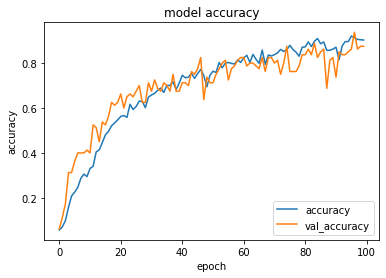

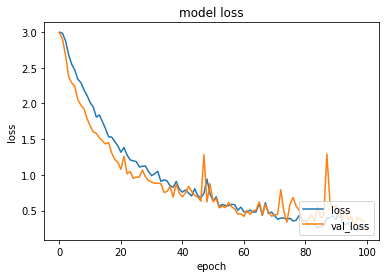

In [34]:
# 学習履歴をプロット
plot_history(history)

In [ ]:
model=model.load_model('/content/drive/MyDrive/data分析/join_csv/lstmpose2.h5')

In [ ]:
target_test=[0.1]*162
one_test = np.array(target_test).reshape(1, 1,162)